# Sesi 12 - Deep Dive ARIMA
## Penjelasan singkat tentang data

you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pmdarima

In [ ]:
# Import library yang akan digunakan
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)


In [ ]:
df_store = pd.read_csv('/content/drive/MyDrive/INDONESIA.AI/DATASET/PROJECT 1/store5.csv')
df_store

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [ ]:
# Hitung jumlah produk unik dalam kolom 'family'
unique_products = df_store['family'].nunique()
unique_products_list = df_store['family'].unique()
print(f"Jumlah produk unik dalam fitur 'family': {unique_products}")
print("Daftar produk:")
for product in unique_products_list:
    print(product)

Jumlah produk unik dalam fitur 'family': 33
Daftar produk:
AUTOMOTIVE
BABY CARE
BEAUTY
BEVERAGES
BOOKS
BREAD/BAKERY
CELEBRATION
CLEANING
DAIRY
DELI
EGGS
FROZEN FOODS
GROCERY I
GROCERY II
HARDWARE
HOME AND KITCHEN I
HOME AND KITCHEN II
HOME APPLIANCES
HOME CARE
LADIESWEAR
LAWN AND GARDEN
LINGERIE
LIQUOR,WINE,BEER
MAGAZINES
MEATS
PERSONAL CARE
PET SUPPLIES
PLAYERS AND ELECTRONICS
POULTRY
PREPARED FOODS
PRODUCE
SCHOOL AND OFFICE SUPPLIES
SEAFOOD


In [ ]:
#--- drop uncessary columns ----
cols_drop = ["id","store_nbr","dcoilwtico"]
df_store = df_store.drop(cols_drop,axis=1)

In [ ]:
#--- convert data to datatime ----
df_store["date"] = pd.to_datetime(df_store["date"],format="%Y-%m-%d")
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         55572 non-null  datetime64[ns]
 1   family       55572 non-null  object        
 2   sales        55572 non-null  float64       
 3   onpromotion  55572 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
#---- create function for filtering ----
def filter_family(df_store: pd.DataFrame,family:str) -> pd.DataFrame:
    filtered_df_store = df_store[df_store["family"]==family].reset_index(drop=True)
    return filtered_df_store


#---- function adfuller test with looping d ---
def adfuller_test(df_store : pd.Series, p: int) -> None:
    if p == 0:
        result = adfuller(df.dropna())
        print("No Differencing")
        print(f"p-value : {result[1]}")
    else:
        diff_df_store= df_store.copy()
        for i in range(p + 1):
            if i == 0:
                result = adfuller(diff_df_store.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")
            else:
                diff_df_store = diff_df_store.diff().dropna().reset_index(drop=True)
                result = adfuller(diff_df_store.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")

<Axes: ylabel='family'>

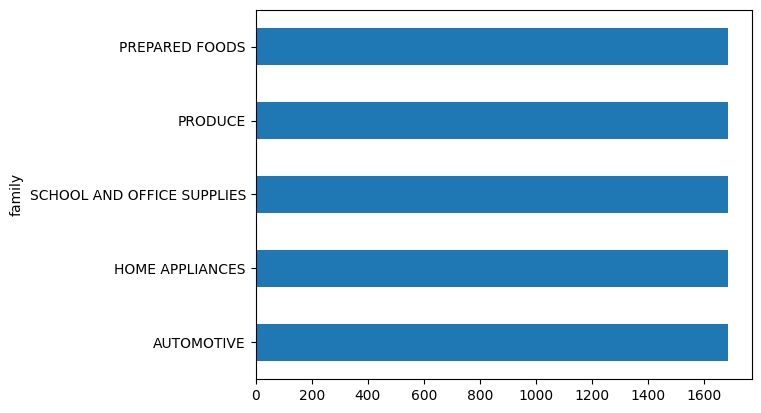

In [ ]:
#--- check----
df_store.family.value_counts().nlargest().plot(kind="barh")

In [ ]:
df_automotive = filter_family(df_store,"AUTOMOTIVE")
df_automotive.head()

,date,family,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,0.0,0
1,2013-01-02,AUTOMOTIVE,6.0,0
2,2013-01-03,AUTOMOTIVE,4.0,0
3,2013-01-04,AUTOMOTIVE,6.0,0
4,2013-01-05,AUTOMOTIVE,4.0,0


<Axes: xlabel='date'>

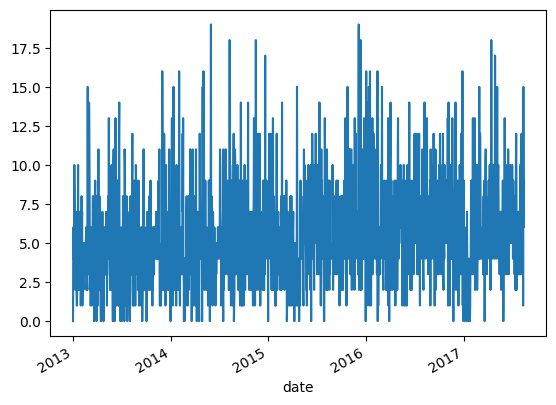

In [ ]:
df_automotive.set_index("date").sales.plot()

Text(0.5, 1.0, 'date sales automotive')

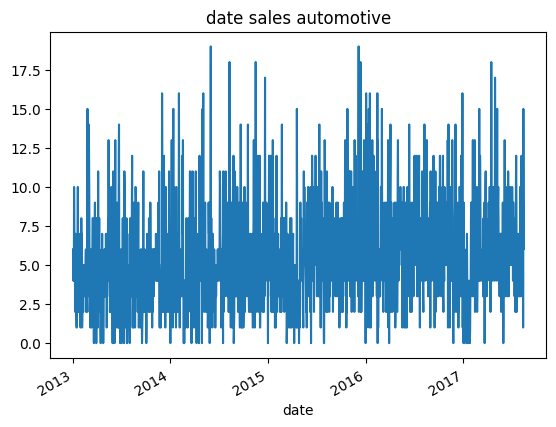

In [ ]:
df_automotive.iloc[1:,:].reset_index(drop=True).set_index("date").sales.plot()
plt.title('date sales automotive')

<Axes: xlabel='date'>

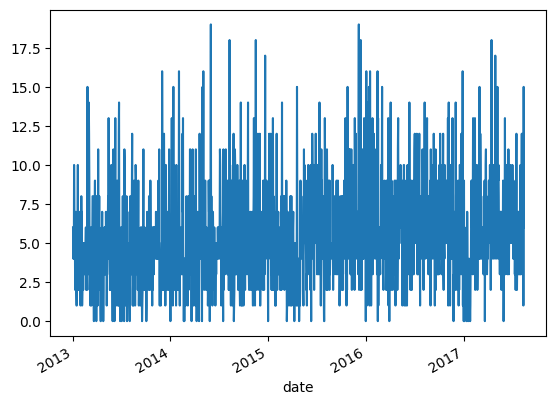

In [ ]:
#data belum full pada 2017-08-14
df_automotive = df_automotive.iloc[1:-1,:].reset_index(drop=True)
df_automotive.set_index("date").sales.plot()

<Axes: xlabel='date'>

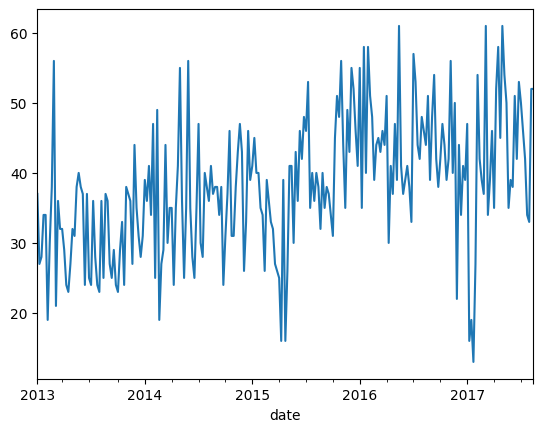

In [ ]:
df_automotive.set_index("date").sales.resample("W-MON").sum().plot()

In [ ]:
df_automotive = df_automotive.set_index("date").sales.resample("W-MON").sum()
df_automotive = np.log(df_automotive)
df_automotive.head()

date
2013-01-07    3.610918
2013-01-14    3.295837
2013-01-21    3.332205
2013-01-28    3.526361
2013-02-04    3.526361
Freq: W-MON, Name: sales, dtype: float64

In [ ]:
df_automotive.index = pd.date_range(start=df_automotive.index.min(), end=df_automotive.index.max(), freq='W-MON')

In [ ]:
#UJI STASIONER
adfuller_test(df_automotive,4)

Differencing level 0
p-value : 0.00031297791894007023
Differencing level 1
p-value : 9.057953662538288e-15
Differencing level 2
p-value : 6.872769528956217e-20
Differencing level 3
p-value : 2.3092160921799504e-14
Differencing level 4
p-value : 5.4439380989787706e-18


<Axes: >

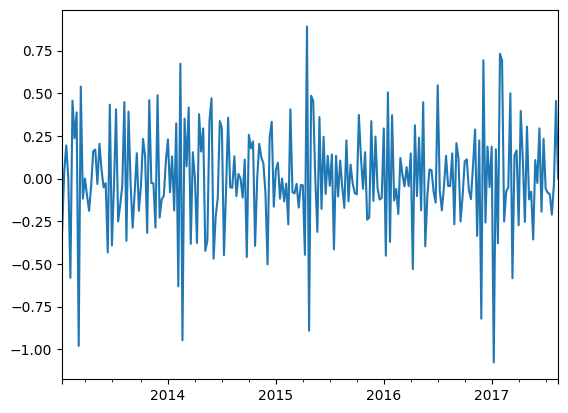

In [ ]:
df_automotive.diff().dropna().plot()

<Axes: >

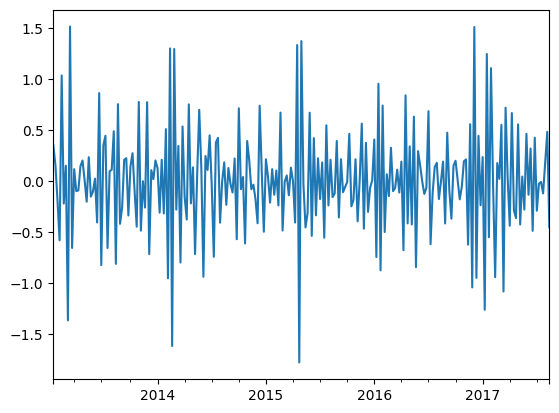

In [ ]:
df_automotive.diff().diff().dropna().plot()

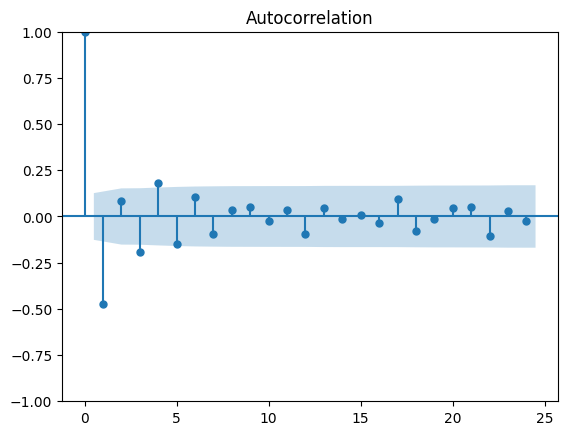

In [ ]:
plot_acf(df_automotive.diff().dropna());

q= 1

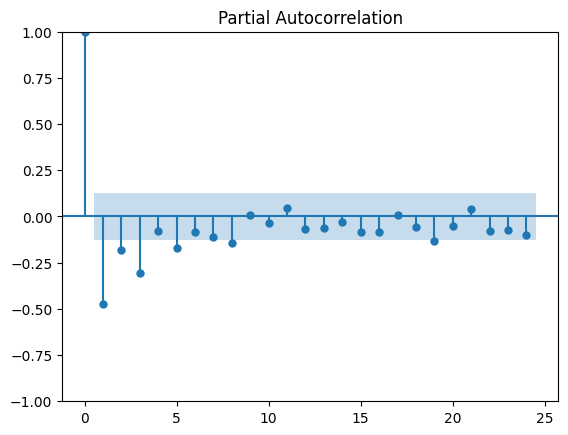

In [ ]:
plot_pacf(df_automotive.diff().dropna());

p = 3

In [ ]:
#ARIMA MODEL

In [ ]:
train_date = int(len(df_automotive)*0.98)
train_date

236

In [ ]:
df_automotive.iloc[:train_date]

2013-01-07    3.610918
2013-01-14    3.295837
2013-01-21    3.332205
2013-01-28    3.526361
2013-02-04    3.526361
                ...   
2017-06-12    3.931826
2017-06-19    3.737670
2017-06-26    3.970292
2017-07-03    3.912023
2017-07-10    3.828641
Freq: W-MON, Name: sales, Length: 236, dtype: float64

In [ ]:
# df_automotive = df_automotive.reset_index()
train_data = df_automotive.iloc[:train_date]
test_data = df_automotive.iloc[train_date:]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima_model_1  = ARIMA(train_data, order=(3,1,1))
model_1 = arima_model_1.fit()

print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  236
Model:                 ARIMA(3, 1, 1)   Log Likelihood                   2.051
Date:                Fri, 21 Jun 2024   AIC                              5.897
Time:                        00:28:37   BIC                             23.195
Sample:                    01-07-2013   HQIC                            12.871
                         - 07-10-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1884      0.062      3.017      0.003       0.066       0.311
ar.L2          0.1533      0.058      2.650      0.008       0.040       0.267
ar.L3         -0.0490      0.070     -0.699      0.4

In [ ]:
#predict train
train_pred = model_1.predict(start=train_data.index.min(), end=train_data.index.max(),typ="linear")
train_pred = pd.DataFrame(train_pred)
train_pred

,predicted_mean
2013-01-07,0.000000
2013-01-14,3.610918
2013-01-21,3.447088
2013-01-28,3.370455
2013-02-04,3.459948
...,...
2017-06-12,3.699539
2017-06-19,3.759005
2017-06-26,3.767591
2017-07-03,3.778861


In [ ]:
predict_train = pd.merge(train_data,train_pred,left_index=True, right_index=True)

rmse_score = mse(np.exp(predict_train.sales), np.exp(predict_train.predicted_mean),squared=False)
print(f"{rmse_score}")

8.786704027487472


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape_train = mape(np.exp(predict_train.sales), np.exp(predict_train.predicted_mean)) * 100
print(f"Percent error {mape_train.round(2)}")

Percent error 19.25


In [ ]:
test_pred = model_1.predict(start=test_data.index.min(), end=test_data.index.max(),typ="linear")
test_pred = pd.DataFrame(test_pred)
test_pred

,predicted_mean
2017-07-17,3.785121
2017-07-24,3.766994
2017-07-31,3.760991
2017-08-07,3.759212
2017-08-14,3.758845


In [ ]:
predict_test = pd.merge(test_data,test_pred,left_index=True, right_index=True)
display(predict_test)


rmse_score = mse(np.exp(predict_test.sales), np.exp(predict_test.predicted_mean),squared=False)
print(f"{rmse_score}")

mape_test = mape(np.exp(predict_test.sales), np.exp(predict_test.predicted_mean)) * 100
print(f"Percent error {mape_test.round(2)}")

,sales,predicted_mean
2017-07-17,3.737670,3.785121
2017-07-24,3.526361,3.766994
2017-07-31,3.496508,3.760991
2017-08-07,3.951244,3.759212
2017-08-14,3.951244,3.758845


8.42521306972688
Percent error 19.46


In [ ]:
def plot_predictions(predict_train: pd.DataFrame, predict_test: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))


    plt.plot(predict_train.index, np.exp(predict_train['sales']), color='green', label='Train Actual')
    plt.plot(predict_train.index, np.exp(predict_train['predicted_mean']), color='red', label='Train Predicted')


    plt.plot(predict_test.index, np.exp(predict_test['sales']), color='yellow', label='Test Actual')
    plt.plot(predict_test.index, np.exp(predict_test['predicted_mean']), color='blue', label='Test Predicted')

    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Actual vs Predicted Sales')
    plt.legend()
    plt.show()

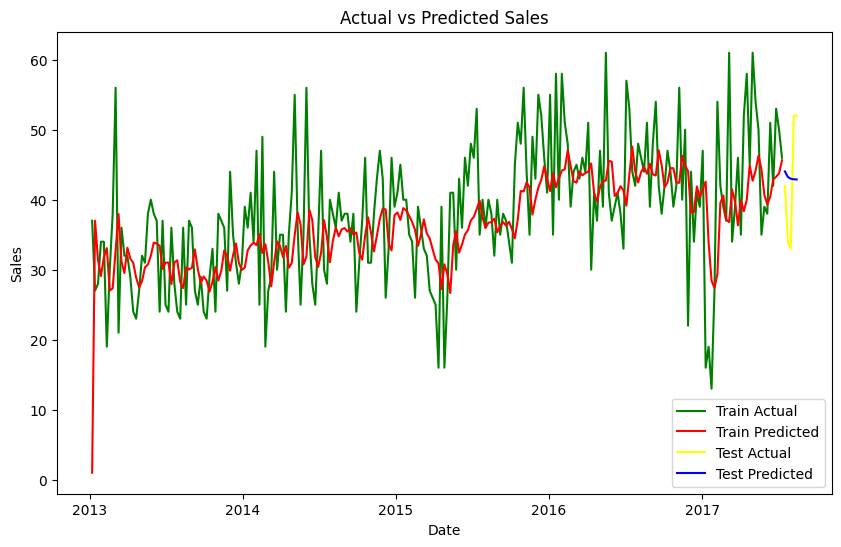

In [ ]:
plot_predictions(predict_train, predict_test)

In [ ]:
!pip install prophet

In [ ]:
train_data = train_data.reset_index().rename(columns={
    "index":"ds",
    "sales":"y"
})


test_data = test_data.reset_index().rename(columns={
    "index":"ds",
    "sales":"y"
})

In [ ]:
from prophet import Prophet
model = Prophet()

In [ ]:
model.fit(train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0cfjziay/12s901kn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0cfjziay/33gc1rjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36672', 'data', 'file=/tmp/tmp0cfjziay/12s901kn.json', 'init=/tmp/tmp0cfjziay/33gc1rjz.json', 'output', 'file=/tmp/tmp0cfjziay/prophet_model2gkinlml/prophet_model-20240621002856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(test_data), freq='W-MON')
future

,ds
0,2013-01-07
1,2013-01-14
2,2013-01-21
3,2013-01-28
4,2013-02-04
...,...
236,2017-07-17
237,2017-07-24
238,2017-07-31
239,2017-08-07


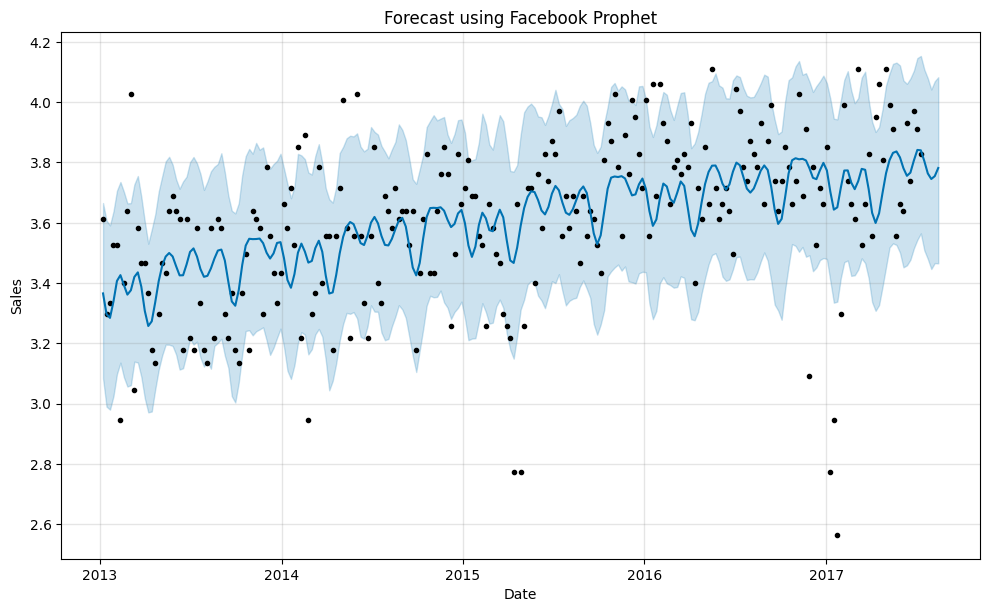

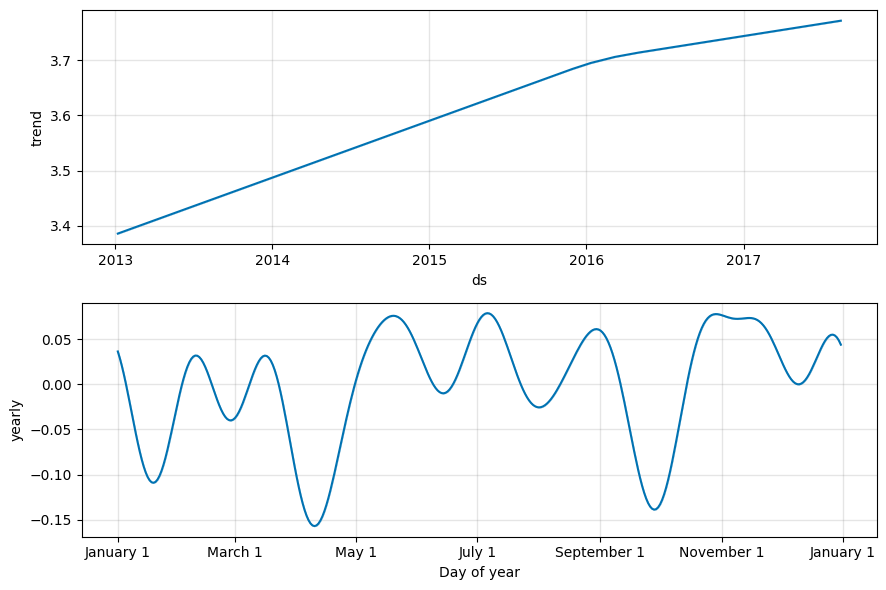

In [ ]:
forecast = model.predict(future)
fig = model.plot(forecast)
plt.title('Forecast using Facebook Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
forecast_test = forecast.iloc[train_date:]

forecast_test = pd.merge(test_data,forecast_test[["ds","yhat"]],on="ds")

mape = mape(np.exp(forecast_test['y']), np.exp(forecast_test['yhat']))
rmse = mse(np.exp(forecast_test['y']), np.exp(forecast_test['yhat']),squared=False)

In [ ]:
mape*100 , rmse

(19.067233257952683, 8.124593772339292)

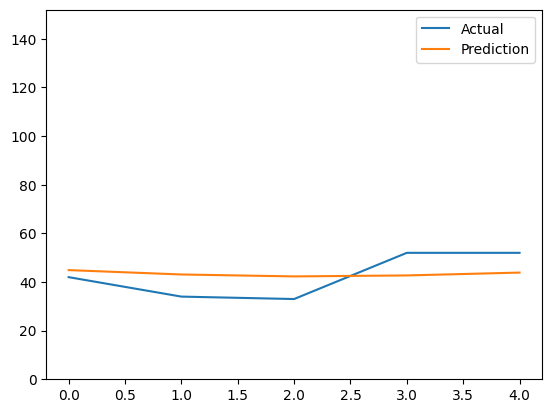

In [ ]:
np.exp(forecast_test["y"]).plot(label="Actual")
np.exp(forecast_test["yhat"]).plot(label="Prediction")

plt.ylim([0,np.exp(forecast_test["y"]).max()+100])
plt.legend()